In [14]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf
#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [2]:
#Import simulated XRD
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
print(theor.shape)
theor = theor.iloc[1:,]
theor_arr = theor.values
print(theor_arr.shape)

# Normalize data for training
ntheor = normdata(theor_arr)
print(ntheor.shape)

#exp = pd.read_csv('Datasets/exp.csv', index_col=0)
#exp_arr = exp.values
#print(exp_arr.shape)

(2402, 1468)
(2401, 1468)
(2401, 734)


In [3]:
#Import dimensionalities
label_theo = pd.read_csv('Datasets/label_theo_dataaug.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

# Load experimental class labels
#label_exp= pd.read_csv('Datasets/label_theo.csv', index_col=0).values
#label_exp = label_exp.reshape([len(label_exp),])

space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

print(len(label_theo))
print(ntheor.shape)

1468
(2401, 734)


In [4]:
#augdata(data,num,par1,minn,maxn)
# Specify how many data points we augmented
th_num = 2000

# Define 2theta range for data augmentation
exp_min = 0
exp_max = 1500
theor_min = 0
theor_max = theor_min+exp_max-exp_min

# Perform data augmentation
augd, pard, crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max) 

# Enconde theoretical labels
label_t = np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i] = space_group_enc.index(pard[i])

print(augd.shape)
print(crop_augd.shape)
print(label_t.shape)

(2401, 2000)
(1500, 2000)
(2000,)


In [5]:
#prepare X et Y
X_th = np.transpose(crop_augd)
#X_th = X_th.reshape(734, 2401, 1)
X_th = X_th.reshape(th_num, exp_max-exp_min, 1)
Y_th = label_t

X_th = X_th.astype(np.float32)
Y_th = Y_th.astype(np.float32)

print(X_th.shape)
print(Y_th.shape)

(2000, 1500, 1)
(2000,)


In [6]:
# Introduction de set de test à partir de la base de données
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_valid, Y_th_train, Y_th_valid = train_test_split(X_th, Y_th, test_size=0.2, random_state=1)

print("X_th_train", X_th_train.shape)
print("X_th_valid", X_th_valid.shape)

print("Y_th_train", Y_th_train.shape)
print("Y_th_valid", Y_th_valid.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_th, Y_th))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_th_valid, Y_th_valid))

print(train_dataset)
print(valid_dataset)

X_th_train (1600, 1500, 1)
X_th_valid (400, 1500, 1)
Y_th_train (1600,)
Y_th_valid (400,)
<TensorSliceDataset shapes: ((1500, 1), ()), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((1500, 1), ()), types: (tf.float32, tf.float32)>


In [7]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for X_th_batch, Y_th_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(X_th_batch.shape, Y_th_batch.shape)
    break

(32, 1500, 1) (32,)


In [8]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=20, strides=1, padding='same', activation='relu', name="conv1")
        self.pool1 = tf.compat.v1.layers.MaxPooling1D(pool_size=3, strides=3, padding='same', name="pool1")
        self.conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=15, strides=1, padding='same', activation='relu', name="conv2")
        self.pool2 = tf.compat.v1.layers.MaxPooling1D(pool_size=2, strides=3, padding='same', name="pool2")
        self.conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, padding='same', activation='relu', name="conv3")
        self.pool3 = tf.compat.v1.layers.MaxPooling1D(pool_size=1, strides=2, padding='same', name="pool3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(256, activation='relu', name="d1")
        self.d2 = tf.keras.layers.Dense(128, activation='relu', name="d2")
        self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")

    def call(self, X_th):
        conv1 = self.conv1(X_th)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool1(conv3)
        #print(conv3)
        flatten = self.flatten(pool3)
        #print(flatten)
        d1 = self.d1(flatten)
        d2 = self.d2(d1)
        #print(d1)
        output = self.out(d2)
        return output

model = ConvModel()
#model.predict(X_th[:,:,:])

In [9]:
#Define loss, optimizer, accuracy for th emodel to compile
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [10]:
# Definition de la fonction qui va entrainer le modele
# On utilise un graphe @
@tf.function
def train_step(X_th, Y_th):
    # Calcul du gradient
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(X_th)
        # Get the error/loss on these predictions
        loss = loss_object(Y_th, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(Y_th, predictions)

In [11]:
# Methode de validation en mode graphe
@tf.function
def valid_step(X_th, Y_th):
    predictions = model(X_th)
    t_loss = loss_object(Y_th, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(Y_th, predictions)

In [12]:
#Iteration du modele
epoch = 20
batch_size = 128
b = 0 #Compter les batchs
for epoch in range(epoch):
    # Training set
    for X_th_batch, Y_th_batch in train_dataset.batch(batch_size): #Iteration dans la dataset
        train_step(X_th_batch, Y_th_batch) #On lance un entrainement
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(Y_th), train_loss.result(), 
            train_accuracy.result()*100
        ), end="") #Informations de l'entrainement
        b += batch_size
    # Validation set
    for X_th_batch, Y_th_batch in valid_dataset.batch(batch_size):
        valid_step(X_th_batch, Y_th_batch) #Mesure precision sur chacun des batch

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    #A la fin de chaque epoch on vide
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 1920/2000, Loss: 0.9702702760696411, Accuracy: 63.529167938232426
Epoch 1, Valid Loss: 0.7309810519218445, Valid Accuracy: 78.75
 Batch 3584/2000, Loss: 0.6980214715003967, Accuracy: 76.38221740722656

KeyboardInterrupt: 

In [ ]:
res = model.predict(X_th[:,:,:])
print(res.shape)
for i in range(200, 250):
    print(res[i], label_theo[i])

In [ ]:
print(res.shape)
for i in range(1, 10):
    print(res[i], label_theo[i])

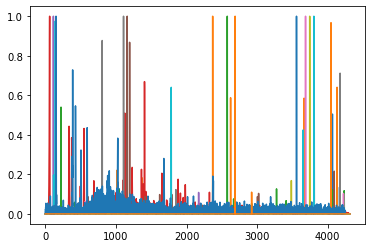

NameError: name 'pard' is not defined

In [15]:
#Load experimental data as dataframe
exp = pd.read_csv('Datasets/exp2.csv', index_col=0)
exp_arr = exp.values
#exp_arr = exp_arr.astype(np.float32)
#print(exp_arr.shape)

#Normalisation
nexp = normdata(exp_arr)
plt.plot(nexp)
plt.show()
#print(nexp.shape)

# Input the num of experimetal data points 
exp_num = 12

# Process data experimental
# Define spectral range for data augmentation
exp_min = 0
exp_max = 1500 
theor_min = 0

#window size for experimental data extraction
window = 15
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing(nexp, exp_min, exp_max, window))
#plt.xlim(0,1500)
#plt.plot(post_exp)
#plt.show()

#plt.xlim(0,1500)
#plt.plot(ntheor)
#plt.show()

#print(post_exp.shape)

# Specify how many data points we augmented
#th_num = 734


#Import dimensionalities
label_exp = pd.read_csv('Datasets/label_exp2.csv', header=None, index_col=0)
label_exp = label_exp[1].tolist()

# Augment data, this may take a bit
newaugd, par = exp_augdata(post_exp, exp_num, label_exp)

# Enconde theoretical labels
label_e = np.zeros([len(par),])
for i in range(len(par)):
    label_e[i] = space_group_enc.index(par[i])


#augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)
     


#prepare arrays
X_exp = np.transpose(post_exp)
X_exp = X_exp.reshape(exp_num, exp_max-exp_min, 1)

X_exp = X_exp.astype(np.float32)

In [ ]:
model.predict(X_exp[:,:,:])